# Self-autoencoding MNIST Digits

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [5]:
import jax
import jax.numpy as jnp
import mediapy
import optax
import PIL.Image
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_to_alive
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.types import Input, State
from datasets import load_dataset
from flax import nnx
from IPython.display import Image, display
from tqdm.auto import tqdm

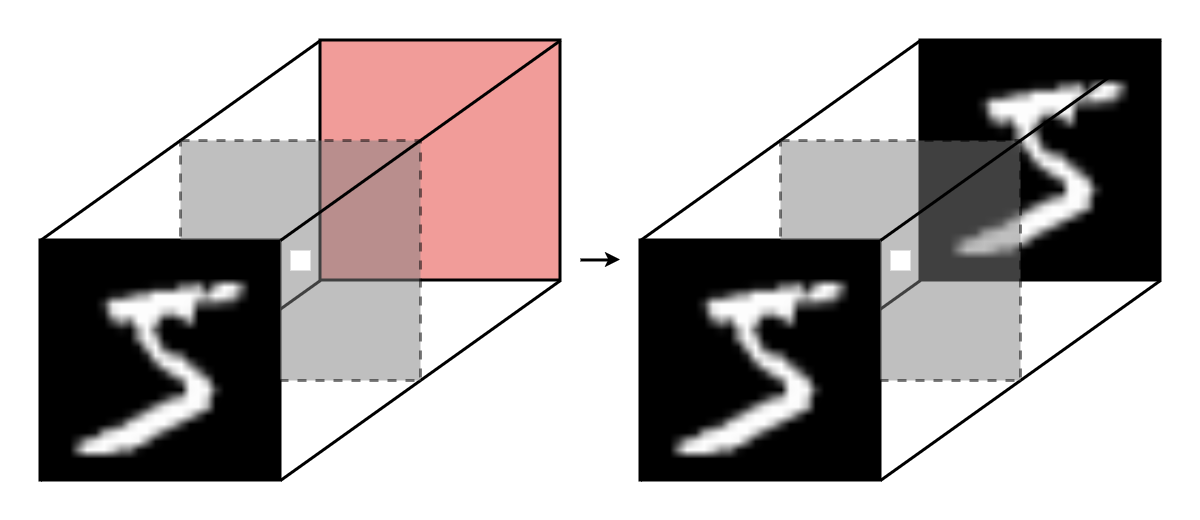

In [2]:
display(Image("../docs/self_autoencoding_mnist.png"))

## Configuration

In [ ]:
seed = 0

channel_size = 32
height, width, depth = 16, 16, 32
num_kernels = 4
hidden_size = 256
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 96
learning_rate = 1e-3

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

In [4]:
ds = load_dataset("ylecun/mnist")

image_train = []
for image in ds["train"]["image"]:
	image_copy = image.copy()
	image_copy.thumbnail((height, width), resample=PIL.Image.Resampling.LANCZOS)
	image_train.append(image_copy)

image_train = jnp.expand_dims(jnp.array(image_train, dtype=jnp.float32) / 255, axis=-1)

mediapy.show_images(ds["train"]["image"][:8], width=128, height=128)

,,,,,,,


In [5]:
def init_state(key):
	state = jnp.zeros((height, width, depth, channel_size))

	target_index = jax.random.choice(key, image_train.shape[0])
	target = image_train[target_index]

	state = state.at[..., 0, -1:].set(target)
	return state, target_index

## Model

In [6]:
perceive = DepthwiseConvPerceive(channel_size, rngs, num_kernels=num_kernels, kernel_size=(3, 3, 3))
update = NCAUpdate(
	channel_size,
	num_kernels * channel_size,
	(hidden_size,),
	rngs,
	cell_dropout_rate=cell_dropout_rate,
	kernel_size=(3, 3, 3),
)

In [7]:
kernel = jnp.concatenate([identity_kernel(ndim=3), grad_kernel(ndim=3)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [8]:
class SelfAutoencodingCA(CA):
	@nnx.jit
	def step(self, state: State, input: Input) -> State:
		perception = self.perceive(state)
		state = self.update(state, perception, input)

		# Mask
		center_cell = state[..., height // 2, width // 2, depth // 2, :]
		state = state.at[..., depth // 2, :].set(0.0)
		state = state.at[..., height // 2, width // 2, depth // 2, :].set(center_cell)

		return state


ca = SelfAutoencodingCA(perceive, update)

In [9]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

Number of params: 44704


## Train

### Pool

In [10]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, pool_size)
state, target_index = jax.vmap(init_state)(keys)

pool = Pool.create({"state": state, "target_index": target_index})

### Optimizer

In [11]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [12]:
def mse(state, target):
	target = jnp.expand_dims(target, axis=-1)
	return jnp.mean(jnp.square(state_to_alive(state) - target))

In [13]:
@nnx.jit
def loss_fn(ca, state, target):
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	# Sample a random step
	index = jax.random.randint(key, (state.shape[0],), num_steps // 2, num_steps)
	state = state[jnp.arange(state.shape[0]), index]

	loss = mse(state, target)
	return loss, state

### Train step

In [14]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	sample_key, init_state_key = jax.random.split(key)

	# Sample from pool
	pool_index, batch = pool.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]
	current_target_index = batch["target_index"]
	current_target = image_train[current_target_index]

	# Sort by descending loss
	sort_index = jnp.argsort(jax.vmap(mse)(current_state, current_target), descending=True)
	pool_index = pool_index[sort_index]
	current_state = current_state[sort_index]
	current_target_index = current_target_index[sort_index]

	# Sample a new target to replace the worst
	new_state, new_target_index = init_state(init_state_key)
	current_state = current_state.at[0].set(new_state)
	current_target_index = current_target_index.at[0].set(new_target_index)
	current_target = image_train[current_target_index]

	(loss, current_state), grad = nnx.value_and_grad(loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params))(
		ca, current_state, current_target
	)
	optimizer.update(grad)

	pool = pool.update(pool_index, {"state": current_state, "target_index": current_target_index})
	return loss, pool

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []

for i in pbar:
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.6f}"})

## Visualize

In [12]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 8)
state, target_index = jax.vmap(init_state)(keys)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=batch_size)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=2 * num_steps, all_steps=True),
		in_axes=(state_axes, 0),
	)
)(ca, state)

mediapy.show_images(image_train[target_index], width=128, height=128)
mediapy.show_videos(state[..., -1, -1], width=128, height=128, codec="gif")

,,,,,,,


,,,,,,,
